In [1]:
from data_utils.ckbc import CKBC

In [6]:
import os

In [61]:
import numpy as np

In [18]:
from scipy.special import softmax

In [36]:
from sklearn.metrics import precision_recall_curve

In [38]:
import matplotlib.pyplot as plt

In [3]:
import json
from models.knowledge_harvester import KnowledgeHarvester

In [40]:
from tqdm import *

In [90]:
def softmax_temperature(x, temperature=1):
    x = np.array(x) / temperature
    return np.exp(x)/sum(np.exp(x))

In [7]:
ckbc = CKBC(file='conceptnet_high_quality.txt')
# knowledge_harvester = KnowledgeHarvester(
#     model_name='roberta-large', max_n_ent_tuples=None)

save_dir = 'debug_0420/'
os.makedirs(save_dir, exist_ok=True)

relation_info = json.load(open('data/relation_info_5seeds.json'))

In [13]:
results_list = os.listdir("debug_0420")

In [123]:
label_dic = {
    0: "initial",
    1: "top-1",
    3: "top-3",
    5: "top-5",
    10: "top-10",
    20: "top-20"
}

In [132]:
for rel, info in tqdm(relation_info.items()):
    if rel not in ckbc._ent_tuples:
        continue
    ent_tuples = ckbc.get_ent_tuples(rel=rel)
    if len(ent_tuples) < 1000:
        continue
    print(rel)

100%|██████████████████████████████| 20/20 [00:00<00:00, 23689.94it/s]

AtLocation
CapableOf
Causes
CausesDesire
Desires
HasA
HasPrerequisite
HasProperty
IsA
MotivatedByGoal
UsedFor


In [142]:
def plot_n(n=0, temperature=1):
    pr_list = []
    int_r = np.arange(0, 1, 1/2000)
    for rel, info in tqdm(relation_info.items()):
        if rel not in ckbc._ent_tuples:
            continue
        ent_tuples = ckbc.get_ent_tuples(rel=rel)
        if len(ent_tuples) < 1000:
            continue
        if n != 0:
            results = [json.load(open(os.path.join("debug_0420", name))) for name in results_list if name.split("_")[0] == rel and "_0." not in name]
            results = sorted(results, key=lambda x: -x["weight"][0])[:n]
        else:
            results = [json.load(open(os.path.join("debug_0420", name))) for name in results_list if name.split("_")[0] == rel and "_0." in name]
        prompt_weights = [i["weight"][0] for i in results]
        # print(prompt_weights)
        prompt_weights = softmax_temperature(prompt_weights, temperature)
        # print(prompt_weights)
        # print(rel, prompt_weights)
        score_dicts = [{(pair[0], pair[1]): score for pair, score in i["scores"]} for i in results]
        y_true, scores = [], []
        for tup in ent_tuples:
            label = ckbc.get_label(rel=rel, ent_tuple=tup)
            y_true.append(label)
            cur_score = sum([i* j[(tup[0], tup[1])] for i, j in zip(prompt_weights, score_dicts)])
            scores.append(cur_score)
        scores_labels = list(zip(scores, y_true, ent_tuples))
        scores_labels.sort(key=lambda x: x[0], reverse=True)
        precision, recall = [], []
        tp, p, t = 0, 0, sum(y_true)
        for score, label, ent_tuple in scores_labels:
            p += 1
            tp += label
            precision.append(tp / p)
            recall.append(tp / t)

        # precision, recall, _ = precision_recall_curve(y_true, scores)
        # print(precision[-10:])
        int_p = np.interp(int_r, recall, precision)
        pr_list.append((int_p))
    plt.plot(int_r, np.array(pr_list).mean(0), label=label_dic[n] + "_temp_" + str(temperature))
    # plt.plot(int_r, np.array(pr_list).mean(0), label=label_dic[n])
        # print(scores)

100%|█████████████████████████████████| 20/20 [00:03<00:00,  6.62it/s]


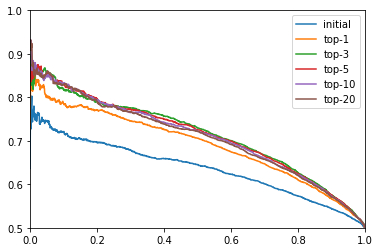

In [130]:
plot_n(0)
plot_n(1)
plot_n(3)
plot_n(5)
plot_n(10)
plot_n(20)
plt.legend()
plt.xlim((0, 1))
plt.ylim((0.5, 1))
plt.show()

100%|█████████████| 20/20 [00:01<00:00, 11.69it/s]


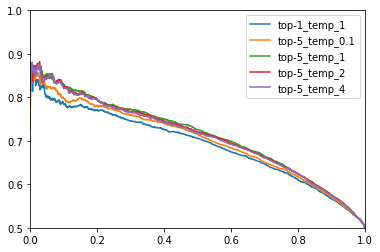

In [143]:
plot_n(1, 1)
plot_n(5, 0.1)
plot_n(5, 1)
plot_n(5, 2)
plot_n(5, 4)
plt.legend()
plt.xlim((0, 1))
plt.ylim((0.5, 1))
plt.show()

the key difference may be the unstability of seed entity pairs..(the so-called top-1 prompt on seed entity pairs may be not best)

弥补了seed entity pairs少，不robust的问题，是针对我们setting的一个design. 之前的想法效果不好/有人提过

seed entity pairs

In [ ]:
openai.Completion.create(engine=’davinci’, prompt=”q: What is the capital of france?\na:”, logprobs = 5, stop = “\n”, temperature=0)

In [137]:
def plot_best_one():
    pr_list = []
    int_r = np.arange(0, 1, 1/2000)
    for rel, info in tqdm(relation_info.items()):
        if rel not in ckbc._ent_tuples:
            continue
        ent_tuples = ckbc.get_ent_tuples(rel=rel)
        if len(ent_tuples) < 1000:
            continue
        results = [json.load(open(os.path.join("debug_0420", name))) for name in results_list if name.split("_")[0] == rel and "_0." not in name]
        results = sorted(results, key=lambda x: -x["weight"][0])[:]
        # prompt_weights = [i["weight"][0] for i in results]
        # print(prompt_weights)
        # prompt_weights = softmax_temperature(prompt_weights, temperature)
        # print(prompt_weights)
        # print(rel, prompt_weights)
        score_dicts = [{(pair[0], pair[1]): score for pair, score in i["scores"]} for i in results]
        
        best_int_p = np.zeros(2000)
        for prompt_score in score_dicts:
            y_true, scores = [], []
            for tup in ent_tuples:
                label = ckbc.get_label(rel=rel, ent_tuple=tup)
                y_true.append(label)
                cur_score = prompt_score[(tup[0], tup[1])]
                scores.append(cur_score)
            scores_labels = list(zip(scores, y_true, ent_tuples))
            scores_labels.sort(key=lambda x: x[0], reverse=True)
            precision, recall = [], []
            tp, p, t = 0, 0, sum(y_true)
            for score, label, ent_tuple in scores_labels:
                p += 1
                tp += label
                precision.append(tp / p)
                recall.append(tp / t)
            cur_int_p = np.interp(int_r, recall, precision)
            if best_int_p[1000] < cur_int_p[1000]:
                best_int_p = cur_int_p 
        pr_list.append((best_int_p))
    # plt.plot(int_r, np.array(pr_list).mean(0), label=label_dic[n] + "_temp_" + str(temperature))
    plt.plot(int_r, np.array(pr_list).mean(0), label="best")
        # print(scores)

100%|█████████████| 20/20 [00:01<00:00, 11.17it/s]


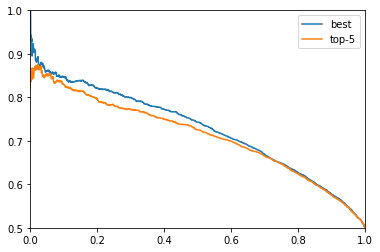

In [139]:
plot_best_one()
plot_n(5)
plt.legend()
plt.xlim((0, 1))
plt.ylim((0.5, 1))
plt.show()

确定放哪些结果

In [ ]:
def plot_n(n=0, seeds=5):
    pr_list = []
    int_r = np.arange(0, 1, 1/2000)
    relation_info = json.load(open('data/relation_info_5seeds.json'))
    for rel, info in tqdm(relation_info.items()):
        if rel not in ckbc._ent_tuples:
            continue
        ent_tuples = ckbc.get_ent_tuples(rel=rel)
        if len(ent_tuples) < 1000:
            continue
        if n != 0:
            results = [json.load(open(os.path.join("debug_0420", name))) for name in results_list if name.split("_")[0] == rel and "_0." not in name]
            results = sorted(results, key=lambda x: -x["weight"][0])[:n]
        else:
            results = [json.load(open(os.path.join("debug_0420", name))) for name in results_list if name.split("_")[0] == rel and "_0." in name]
        prompt_weights = [i["weight"][0] for i in results]
        # print(prompt_weights)
        prompt_weights = softmax_temperature(prompt_weights, temperature)
        # print(prompt_weights)
        # print(rel, prompt_weights)
        score_dicts = [{(pair[0], pair[1]): score for pair, score in i["scores"]} for i in results]
        y_true, scores = [], []
        for tup in ent_tuples:
            label = ckbc.get_label(rel=rel, ent_tuple=tup)
            y_true.append(label)
            cur_score = sum([i* j[(tup[0], tup[1])] for i, j in zip(prompt_weights, score_dicts)])
            scores.append(cur_score)
        scores_labels = list(zip(scores, y_true, ent_tuples))
        scores_labels.sort(key=lambda x: x[0], reverse=True)
        precision, recall = [], []
        tp, p, t = 0, 0, sum(y_true)
        for score, label, ent_tuple in scores_labels:
            p += 1
            tp += label
            precision.append(tp / p)
            recall.append(tp / t)

        # precision, recall, _ = precision_recall_curve(y_true, scores)
        # print(precision[-10:])
        int_p = np.interp(int_r, recall, precision)
        pr_list.append((int_p))
    # plt.plot(int_r, np.array(pr_list).mean(0), label=label_dic[n] + "_temp_" + str(temperature))
    plt.plot(int_r, np.array(pr_list).mean(0), label=label_dic[n])
        # print(scores)

scoring: 

 + PR curve (entity pairs)

search + scoring: 
+ Classifier
+ Human eval (should be higher than classifier. Argument: classifier is not good)

minor point: what if we don't have seed entity pairs?